# Generative Model Tutorial

This notebooks explains the model powering https://rt.live with its nowcast of the effective reproduction number. It is based on [version 1.0.0](https://github.com/rtcovidlive/covid-model/commit/50bf8e4ace5b973b3d323f058ad613d4b02f4c2f) of the model.

## What is Rt?
$R_0$ ("R-naught") describes the reproduction factor of a disease -- i.e. how many other people does one infected person pass the disease to. If this quantity is larger than 1 we have an epidemic on our hands, as is the case for COVID-19. 

$R_0$ assumes, however, that there are no counter-measures being implemented to curb spread of the virus. Thus, the more critical measure to track is $R_e(t)$ -- the time-changing effective reproduction factor, i.e. on a given day $t$, how many people does one person infect. 

As lockdowns and social distancing measures are put in place we expect this quantity to drop, ideally below the critical quantity of 1 because then, over time, the disease would just wimper out.

Usually we'd extract $R_e(t)$ from something like an [SIR (susceptible-infected-recovered) model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) or an SEIR (which adds an exposed category), which are classic epidemiological compartment models. 

An SIR model is in fact what `rt.live` used in the beginning. However, SIR/SEIR models are also just approximations of the real thing and come with quite a few assumptions baked in. The current model is simpler and makes fewer assumptions. In addition, the SIR model is described as an ODE which causes various technical problems. Solving the ODE is quite time-intensive and while closed-form approximations exist and are faster, we found that they are quite unreliable.

Instead, the current model uses a simple generative logic to explain how an initial pool of infected people spreads the disease at each time-point, according to the current reproduction factor.

## The generative model

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('talk')
from scipy import stats
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.patients import get_delay_distribution
from covid.data import summarize_inference_data, get_and_process_covidtracking_data
%config InlineBackend.figure_format = 'retina'

df = get_and_process_covidtracking_data(
    run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

Let's assume that for an idealized disease we start with a single infected patient (primary infection) on day $0$ that is infectous for a single day only and on that day goes on to infect 2 people (secondary infection) which become sick the next day. This disease thus has a reproduction factor $R_0$ of 2. We could write that on day $t$ the number of newly infected $y_t$ is:

$$ y_t = y_{t-1} \cdot R_0 $$

Quite simple. This logic gives rise to the classic exponential growth pattern we see in epidemics:

In [2]:
# Code optimized for readability, not speed
n_days = 10
ts = np.arange(n_days)
R0 = 2
y = np.zeros(n_days) 

y[0] = 1 # starting with 1 infected
for t in ts[1:]:
    y[t] = y[t-1] * R0

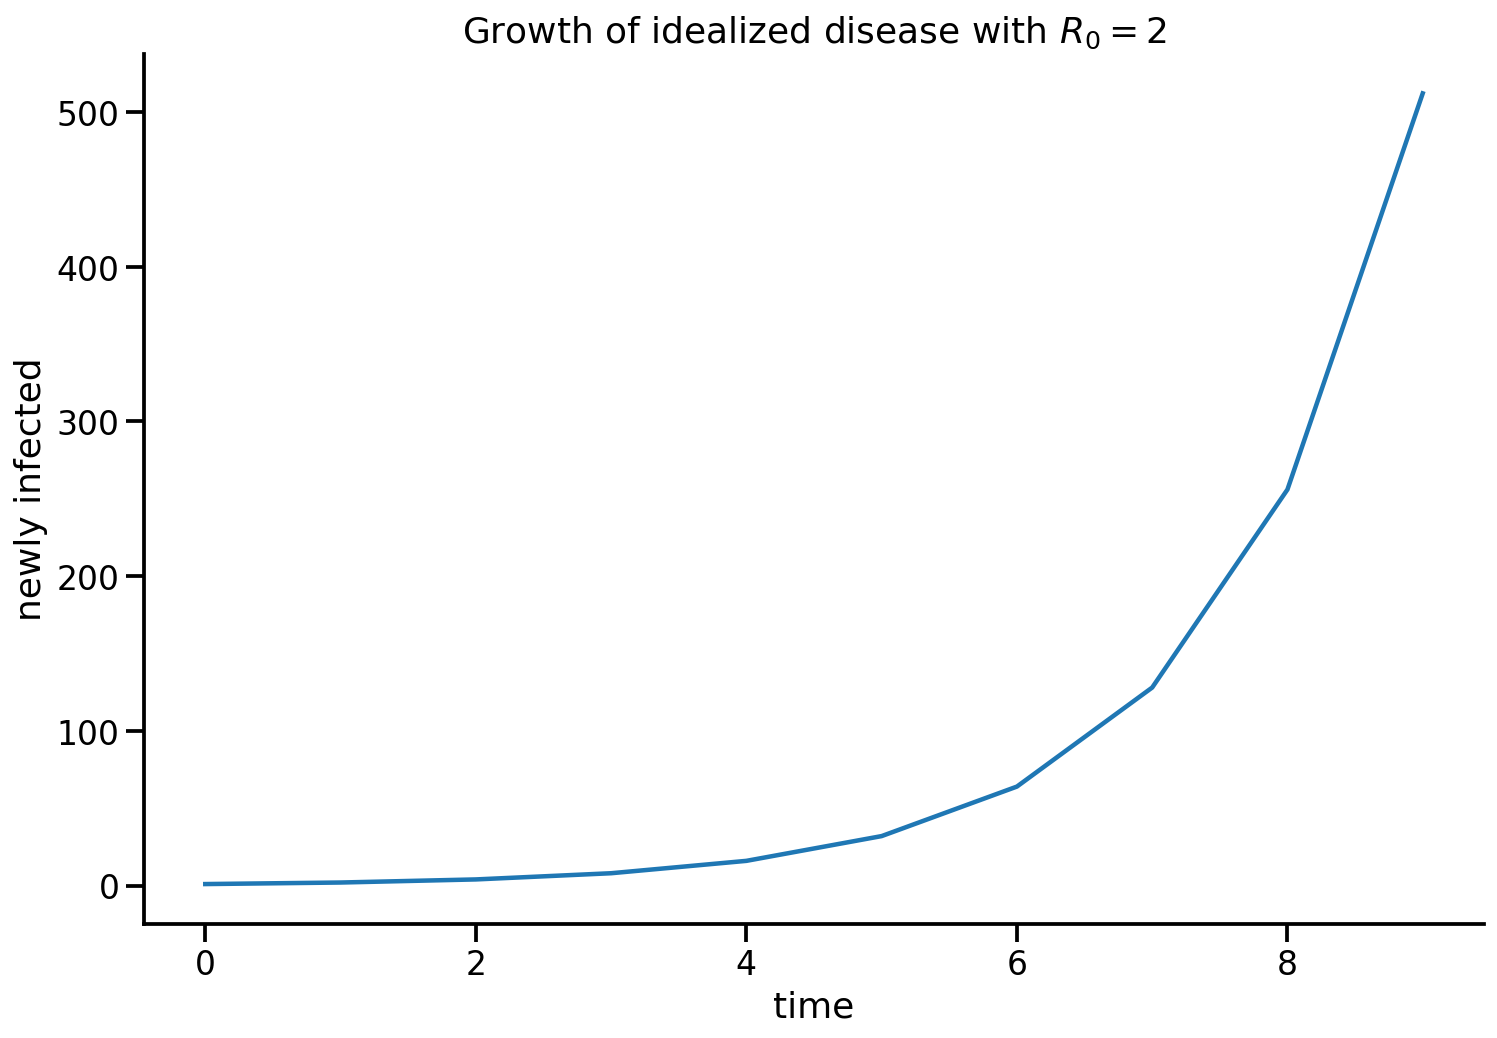

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, y);
ax.set(xlabel='time', ylabel='newly infected', 
       title='Growth of idealized disease with $R_0 = 2$'); sns.despine();

However, as we discussed we care more about the effective reproduction rate as a function of time $R_e(t)$. We can just switch that into our idealized generative model:

$$ y_t = y_{t-1} \cdot R_e(t) $$

In [4]:
n_days = 10
ts = np.arange(n_days)
Rt = np.linspace(2, 1, n_days) # Assuming Re(t) goes from 2 to 1
y = np.zeros(n_days)

y[0] = 1 # starting with 1 infected
for t in ts[1:]:
    y[t] = y[t-1] * Rt[t]

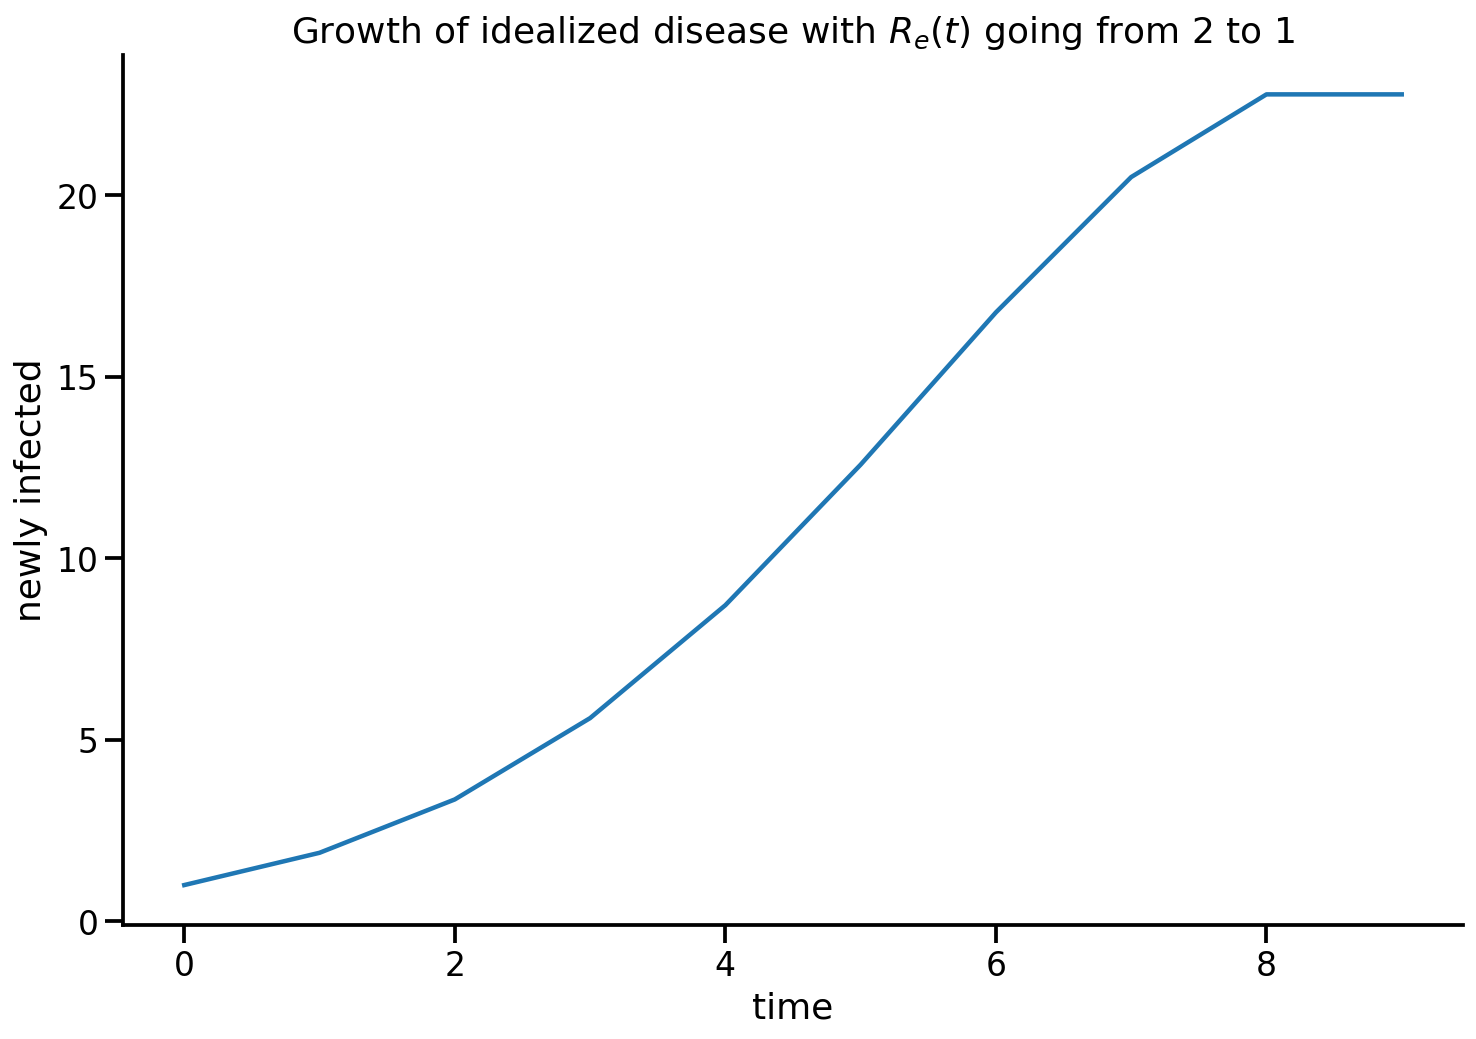

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, y);
ax.set(xlabel='time', ylabel='newly infected', 
       title='Growth of idealized disease with $R_e(t)$ going from 2 to 1'); 
sns.despine();

You can see that on the last day, where $R_e(t)$ is 1 we get the same number of newly infected as on the previous day, because every infected infects just one more person.

The implicit assumption in the generative process above is that an infected person is only infectious for a single day and that it then takes just one day to infect other people.

In reality, the time it takes for the primary person to infect others follows a distribution. They might infect one person the next day, two the day after etc. This delay distribution is officially known as the "*generation time*" and we will model it with a probability distribution from [this study](https://www.ijidonline.com/article/S1201-9712%2820%2930119-3/pdf) (the study actually provides an estimate for something closely related to the generation time but it's fine to use it for this).

The paper includes a simple formulation of how to derive the generation time distribution for COVID-19:

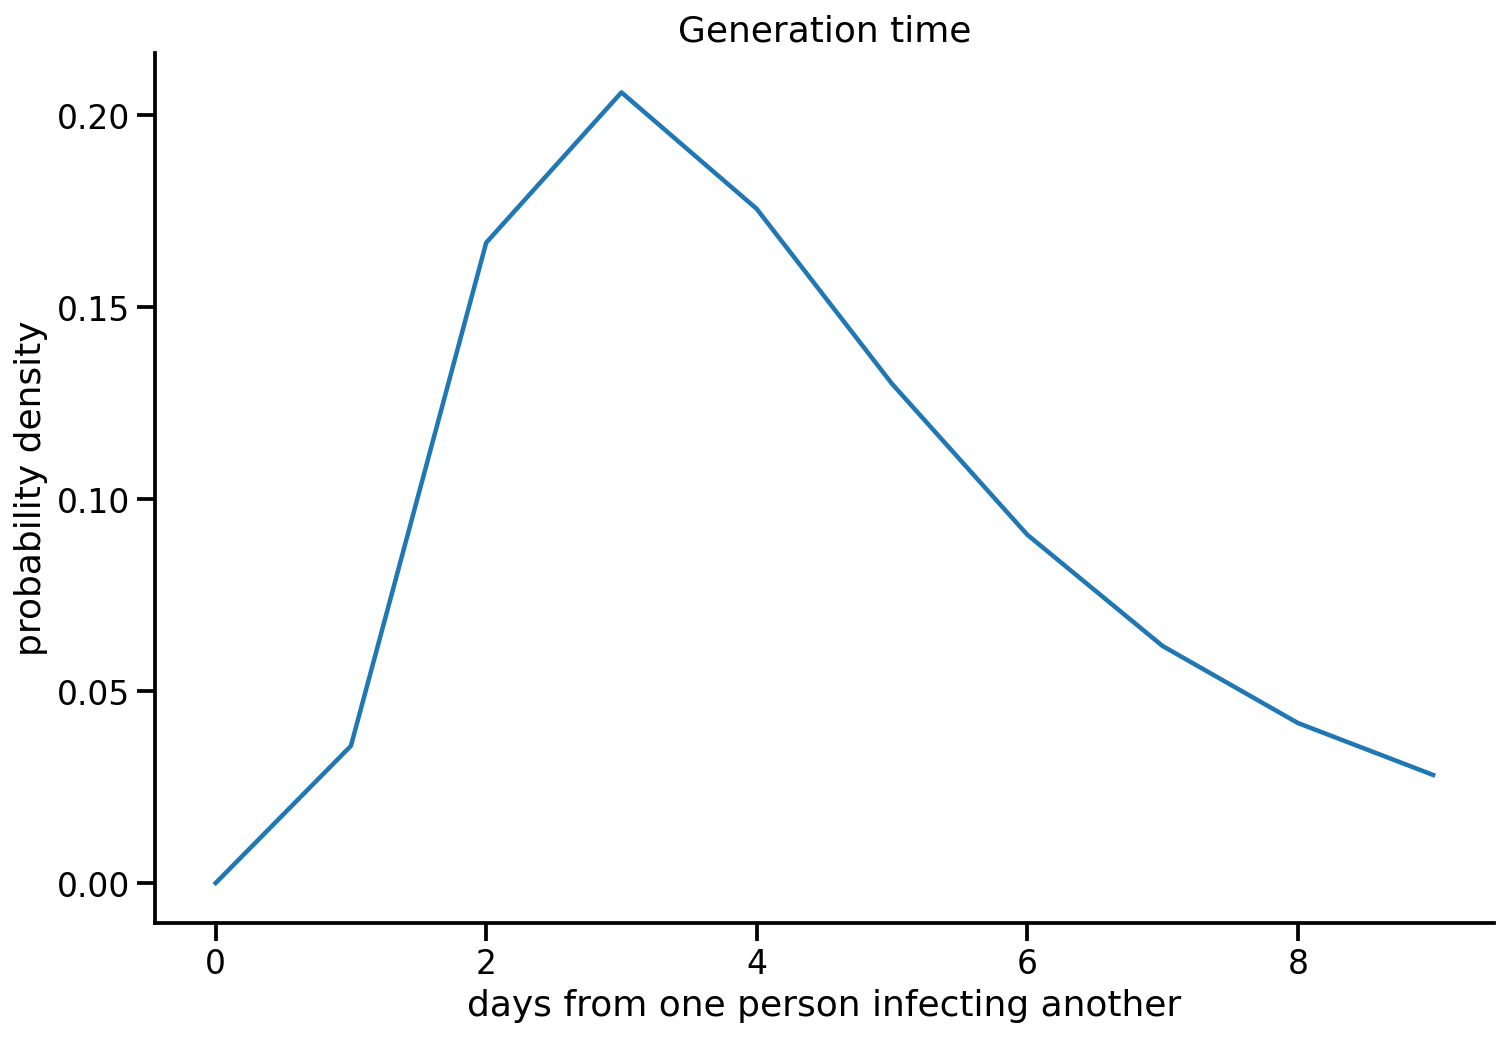

In [6]:
mean_si = 4.7
std_si = 2.9
mu_si = np.log(mean_si ** 2 / np.sqrt(std_si ** 2 + mean_si ** 2))
sigma_si = np.sqrt(np.log(std_si ** 2 / mean_si ** 2 + 1))
generation_time = stats.lognorm(scale=np.exp(mu_si), s=sigma_si)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, generation_time.pdf(ts))
ax.set(xlabel='days from one person infecting another',
       ylabel='probability density',
       title='Generation time'); sns.despine();

In order to include this effect in our generative model we need to do a convolution. Intuitively, instead of the new cases on day $t$ depending only on the new cases on day $t-1$, they now depend on the new cases on (potentially) all previous days because it could have taken 5 days between the time a person got infected and infected another person. We need to take all of these previously infected people into account and by which probability they infect people today. 

We accomplish this by weighting the number of newly infected people $i$ days ago -- $y_{t-i}$ -- by the generation time $g_i$ for that particular delay as well as the effective reproduction number on that day $R_e(t-i)$:

$$ y_t = \sum_{i=1}^{M}y_{t-i} R_e(t-i) g_i  $$

For further details on this generative process see this post: https://staff.math.su.se/hoehle/blog/2020/04/15/effectiveR0.html.

Updating our generative process model accordingly we get:

In [7]:
n_days = 30
ts = np.arange(0, n_days)
Rt = np.linspace(2, 1, n_days) # Assuming Re(t) goes from 2 to 1
y = np.zeros(n_days) 
y[0] = 1 # starting with 1 infected

for t in ts[1:]:
    # loop over previous days
    for i in range(1, t+1):
        y[t] += y[t - i] * Rt[t - i] * generation_time.pdf(i)

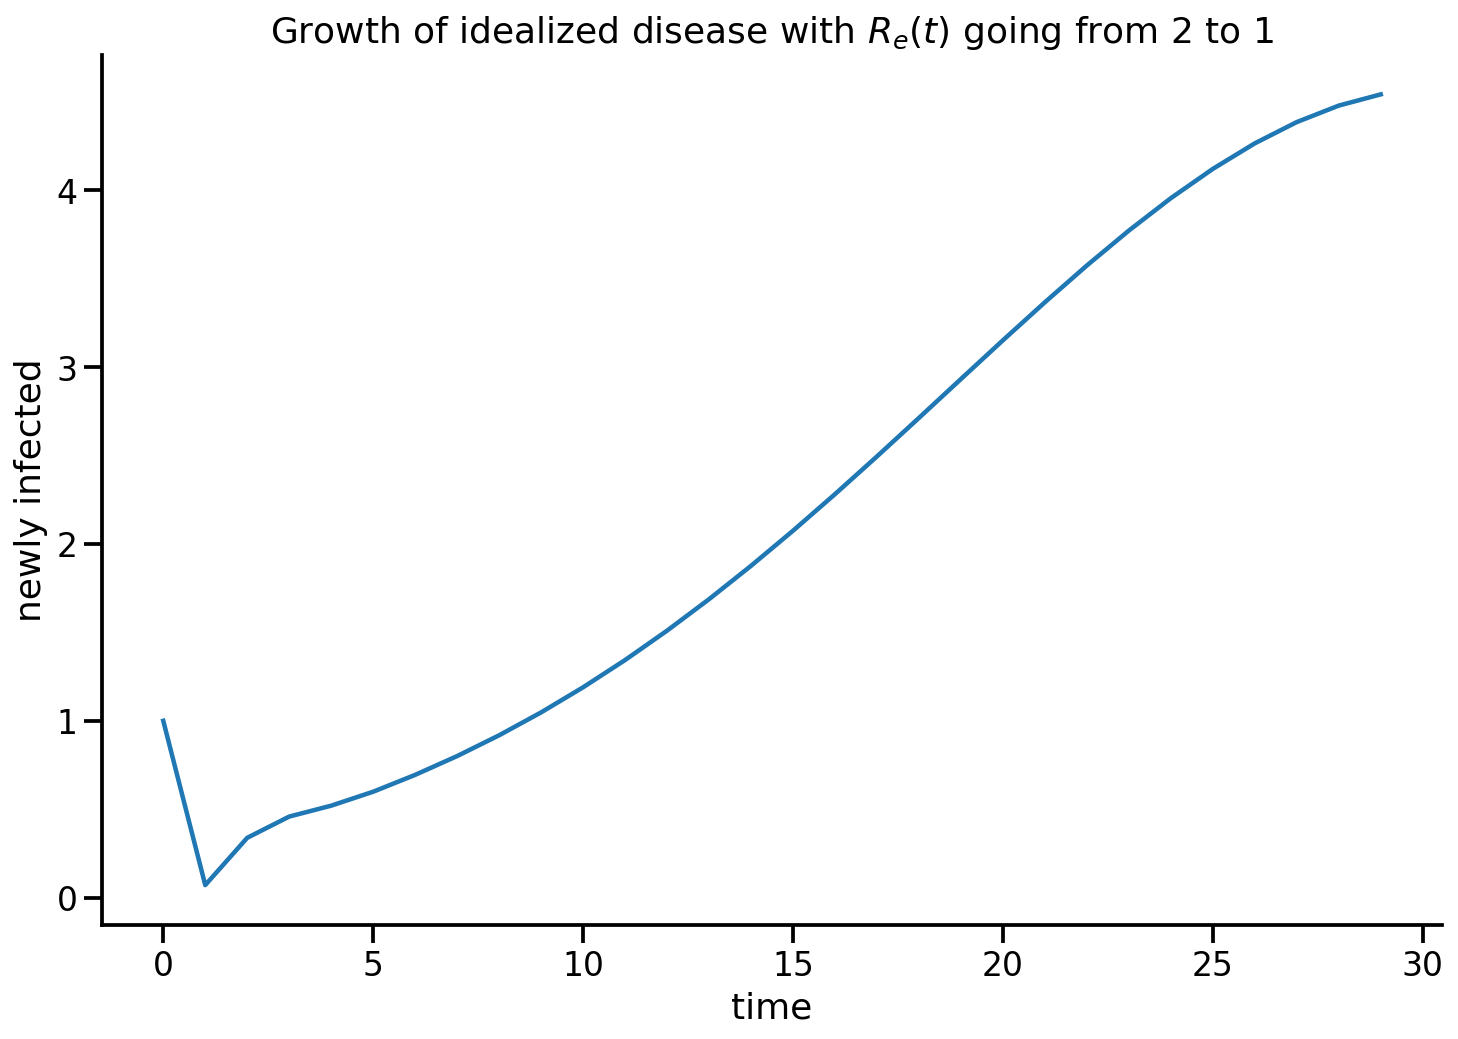

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, y);
ax.set(xlabel='time', ylabel='newly infected', 
       title='Growth of idealized disease with $R_e(t)$ going from 2 to 1');
sns.despine();

As you can see, taking the delay between one person passing the disease onto the next into account slows the spread significantly. The longer the *generation time*, the slower the spread.


## Getting to number of infected

So far we have a generative model of how people transmit the disease from one person to the next. However, we don't have data of when people transmitted the disease, we have data of who got a positive test result. So we need to delay this function even further by when an infected patient actually shows up as as a positive test in our data. 

To do this we will use the distribution of the delay between infection and confirmed positive test, also known as the *onset delay distribution*. To estimate this distribution we can use data from the [Open COVID-19 Data Working Group](https://github.com/beoutbreakprepared/nCoV2019) which asked COVID-19 patients how long ago their symptoms started ([Xu et al., 2020](https://www.nature.com/articles/s41597-020-0448-0)). However, symptom onset isn't the same as when someone got infected because there is incubation period during which the virus is spreading in the body while no symptoms are noticeable. To fix this we just an incubation period to the beginning of the *onset delay distribution* ([rt.live](https://rt.live) assumes 5 days). You can see this offset in the flat region from days 1-5 in the next plot. 

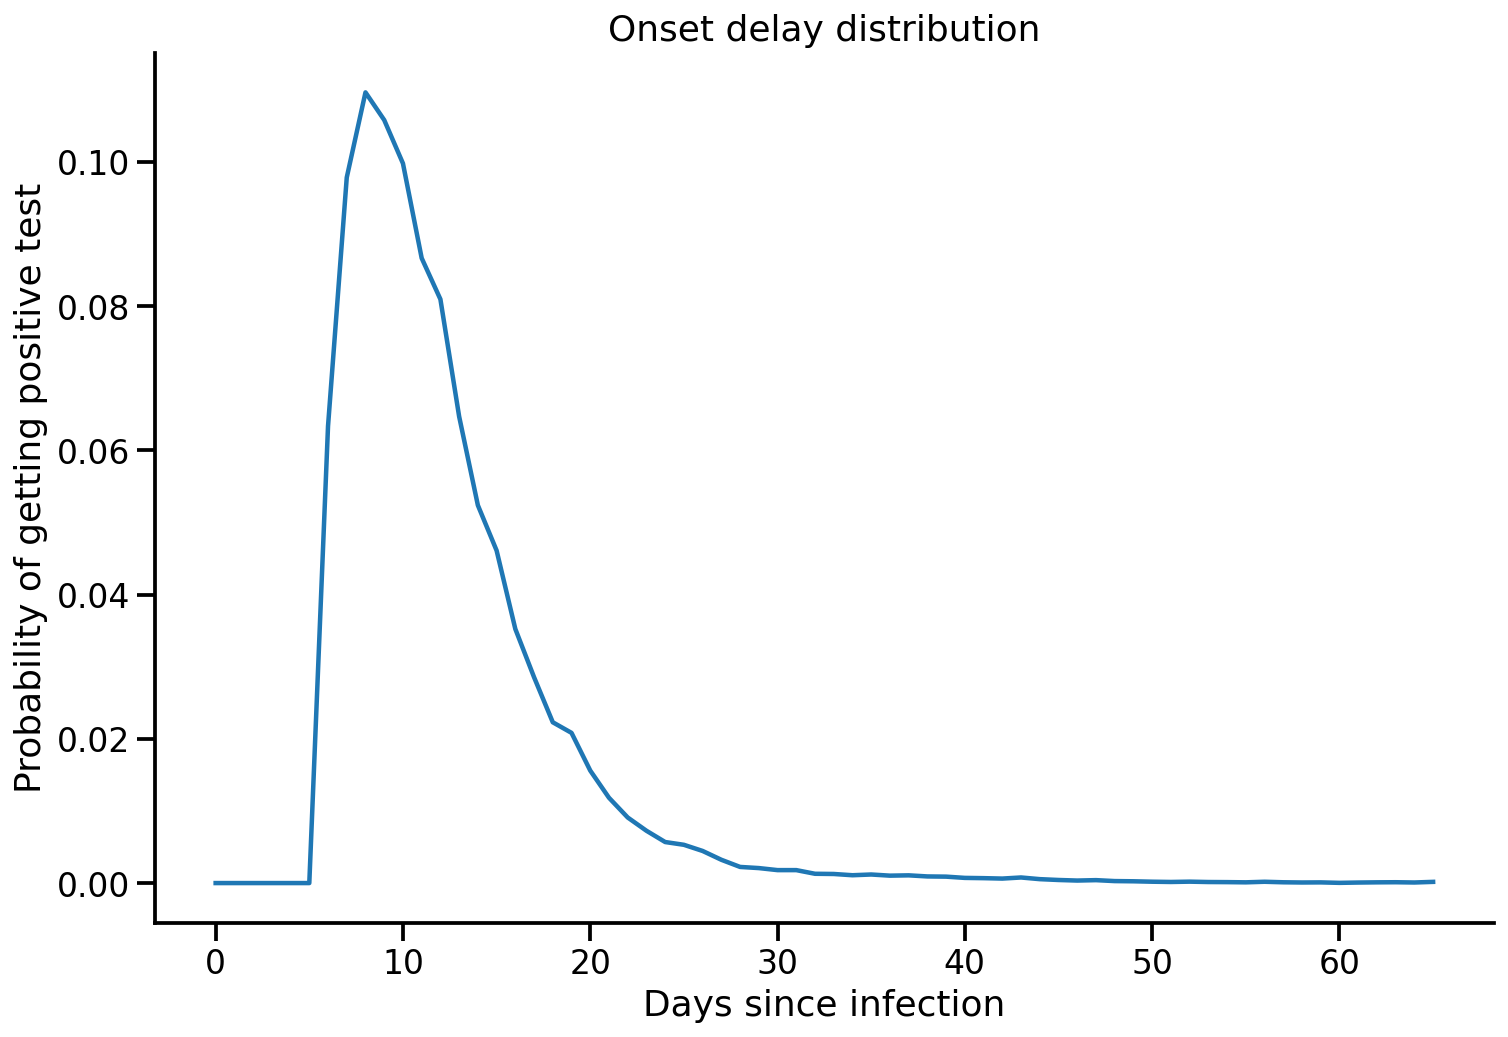

In [9]:
p_delay = get_delay_distribution()
ax = p_delay.plot(figsize=(12, 8))
ax.set(title="Onset delay distribution", 
       ylabel="Probability of getting positive test", 
       xlabel="Days since infection");
sns.despine();

Now all we need to do is convolve the function we have above of how many people got infected each day with the onset delay distribution to get to how many people will show up with a positive test on that day.

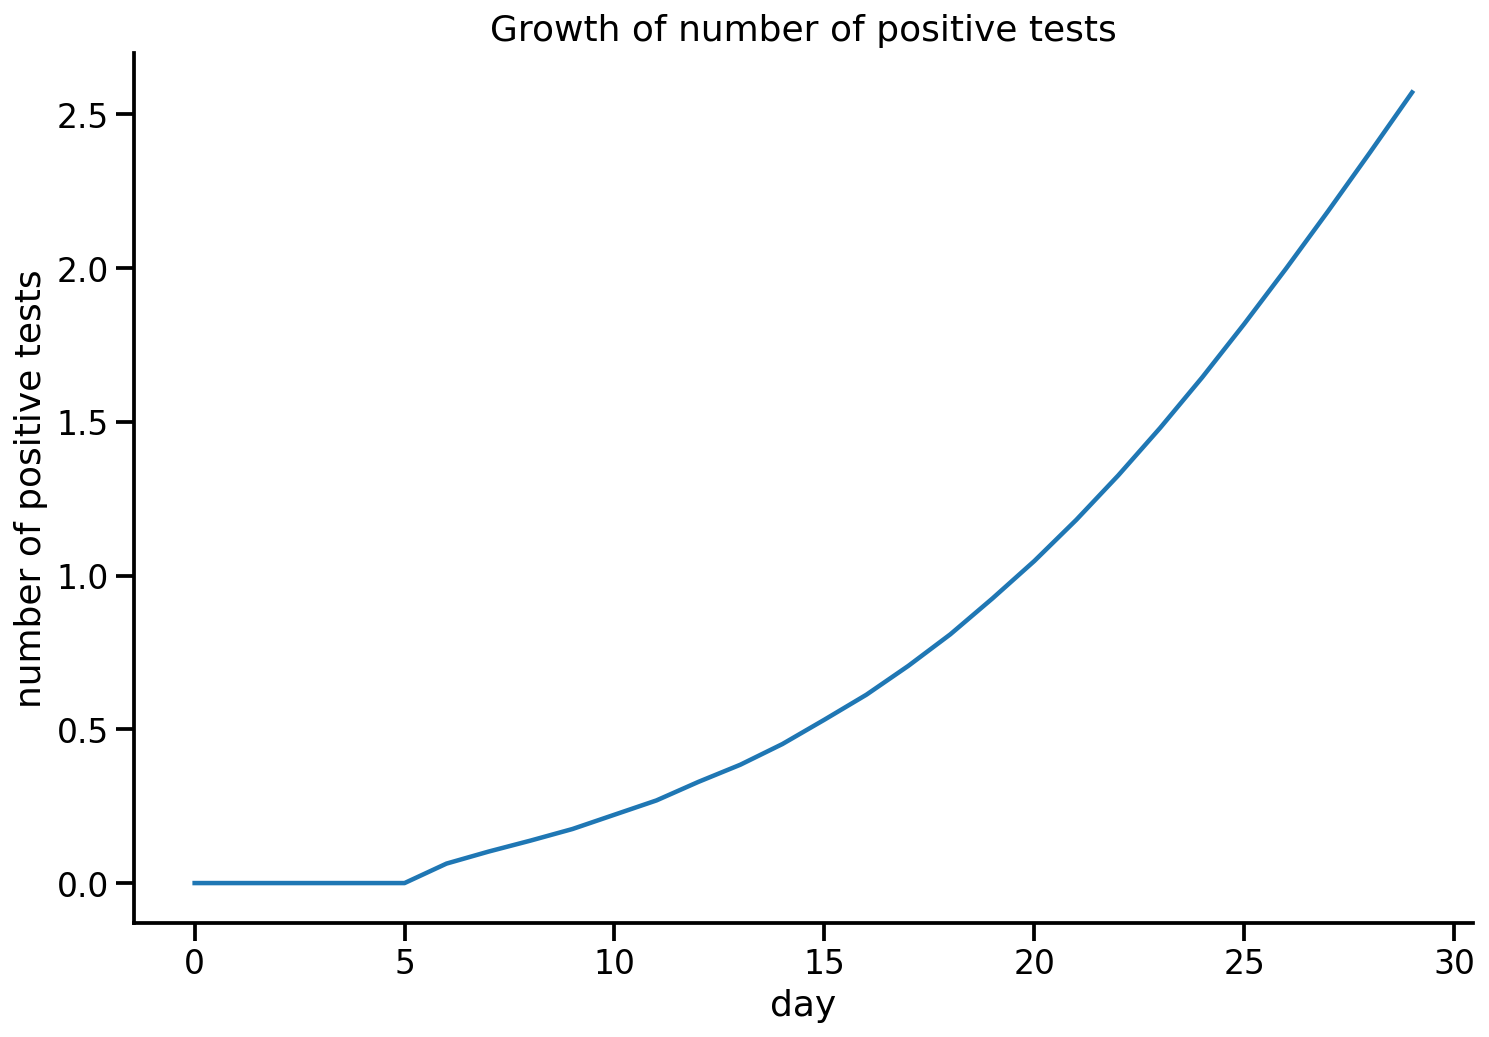

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, np.convolve(y, p_delay)[:n_days])
ax.set(xlabel='day', ylabel='number of positive tests', 
       title='Growth of number of positive tests');
sns.despine();

## Adjusting for number of tests performed

When looking at the number of raw positive tests, it's clear that that number will be influenced by how many people you tested: The more you test, the more cases you will uncover. 

This is important to model because there is huge variability in the number of tests being done over time (ramping up of tests more generally as more testing capacities are created, but also because usually fewer tests are being done on weekends). This would bias our estimate of $R_e(t)$ if not accounted for.

Thus, in the model we multiply the test exposure $e_t$ (a normalized quantity proportional to the number of tests performed) with the number of positive tests from the generative process. Intuitively, if we test twice as much, we expect twice as many positive tests to show up.

Thus, the expected number of positive tests $\tilde{z_t}$ will be:

$$ \tilde{z_t} = z_t \cdot e_t $$

where $z_t$ is the output of the generative model with the delays applied.

## Summarizing the generative process

1. Primary infection occurs (this is the time-point we want Rt to relate to).
2. *Generation time* passes until secondary infection occurs.
3. *Onset time* passes until secondary infected person develops symptoms and tests positive. This is the number of positive tests we'd expect if testing were constant.
4. Multiply number of positive tests (if tests were constant) with the testing exposure to get to the number of expected positives. This is the model output we use to fit the data.

## The Bayesian model in PyMC3

The model in [`PyMC3`](https://docs.pymc.io/) follows the above generative process directly as you can see [in the source](https://github.com/rtcovidlive/covid-model/blob/master/covid/models/generative.py#L143). 

The main addition is that we place a random-walk prior on $R_e(t)$ that injects the knowledge into the model, that the reproduction factor is not changing hugely from day-to-day.

## Using the model interactively

Let's see how to actually use the model interactively. As our example region we use Massachusetts. 

In [11]:
region = "CO"
model_data = df.loc[region]

To run the model we just instantiate it and call `.sample()`:

In [12]:
gm = GenerativeModel(region, model_data)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 10667 seconds.


`summarize_inference_data()` reformats the raw sampling trace so that its easier to work with.

In [13]:
result = summarize_inference_data(gm.inference_data)

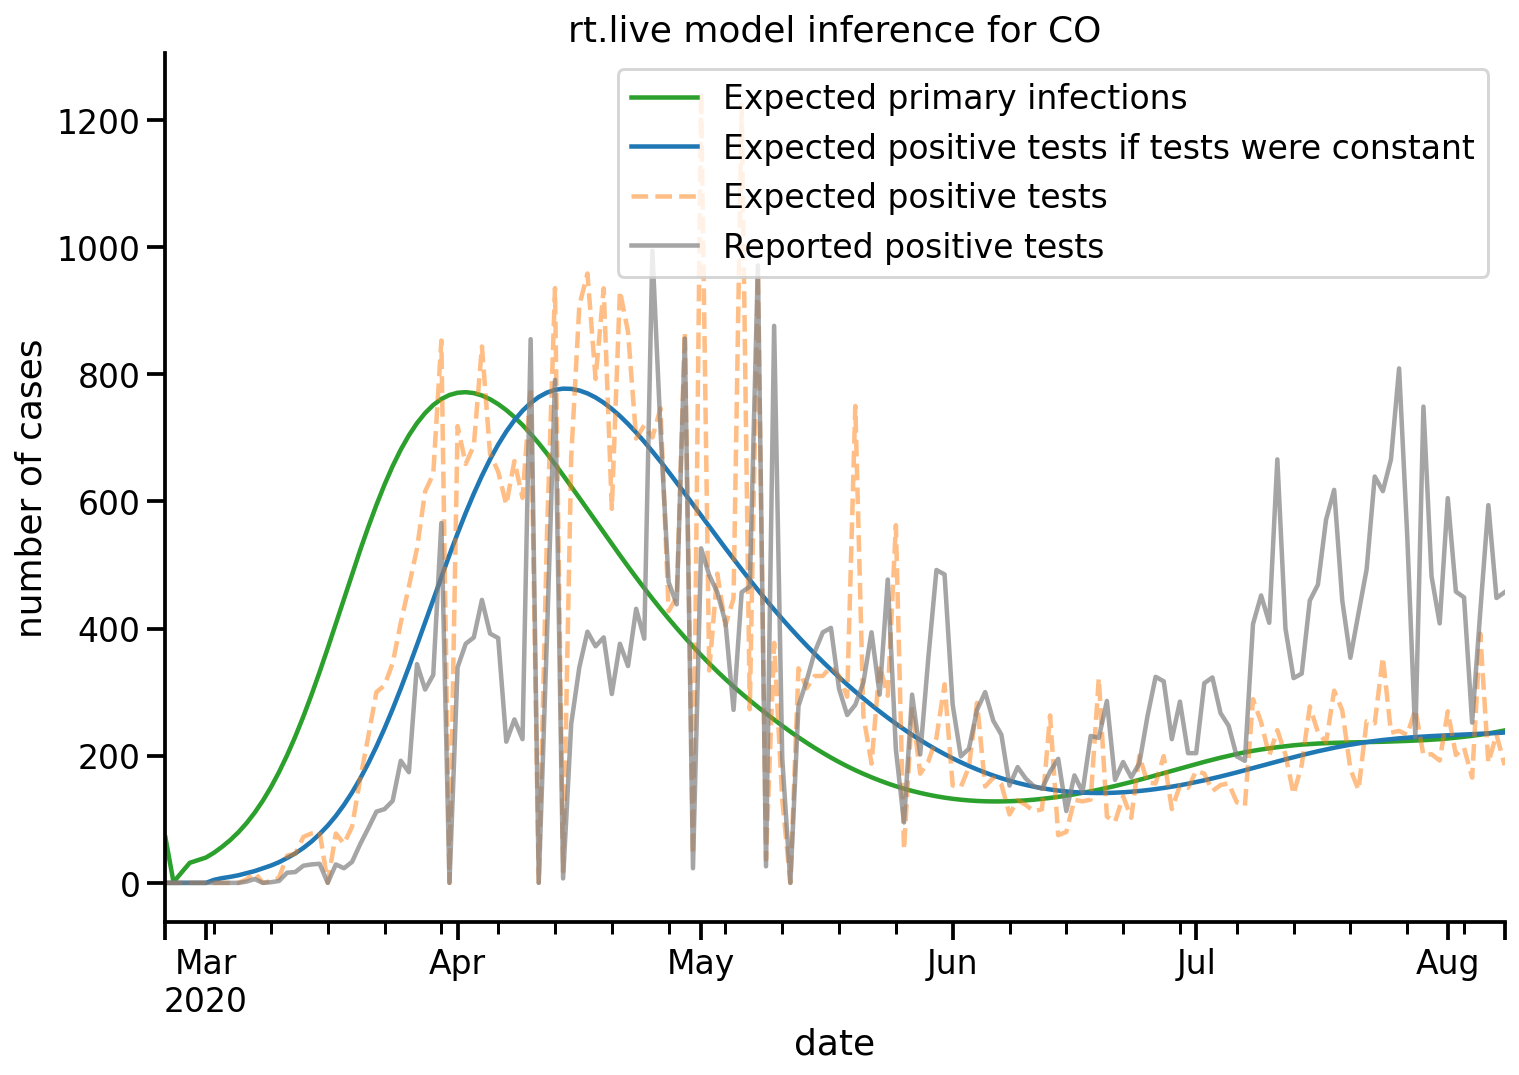

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
result.infections.plot(c="C2", label="Expected primary infections")
result.test_adjusted_positive.plot(c="C0", label="Expected positive tests if tests were constant")
result.test_adjusted_positive_raw.plot(c="C1", alpha=.5, label="Expected positive tests", style="--")
gm.observed.positive.plot(c="C7", alpha=.7, label="Reported positive tests")
fig.set_facecolor("w")
ax.legend();
ax.set(title=f"rt.live model inference for {region}", ylabel="number of cases")
sns.despine();

The plot above shows exactly what's going on in each step. Let's apply the logic backwards this time, going from data to hidden causes. First, we have the observed data of "Reported positive tests" in grey. This is what our model tries to explain with the "Expected positive tests", the output of the model which is derived from the "Expected number of positive tests if tests were constant". This number we convolve with the *onset delay distribution* to get from to "Infection onset", i.e. when did people actually get infected. From there we use the *generation time distribution* to arrive at when the actual transmission of the disease occured.

Our $R_e(t)$ estimate is then based on when the actual transmission occured, not when we observed the positive test:

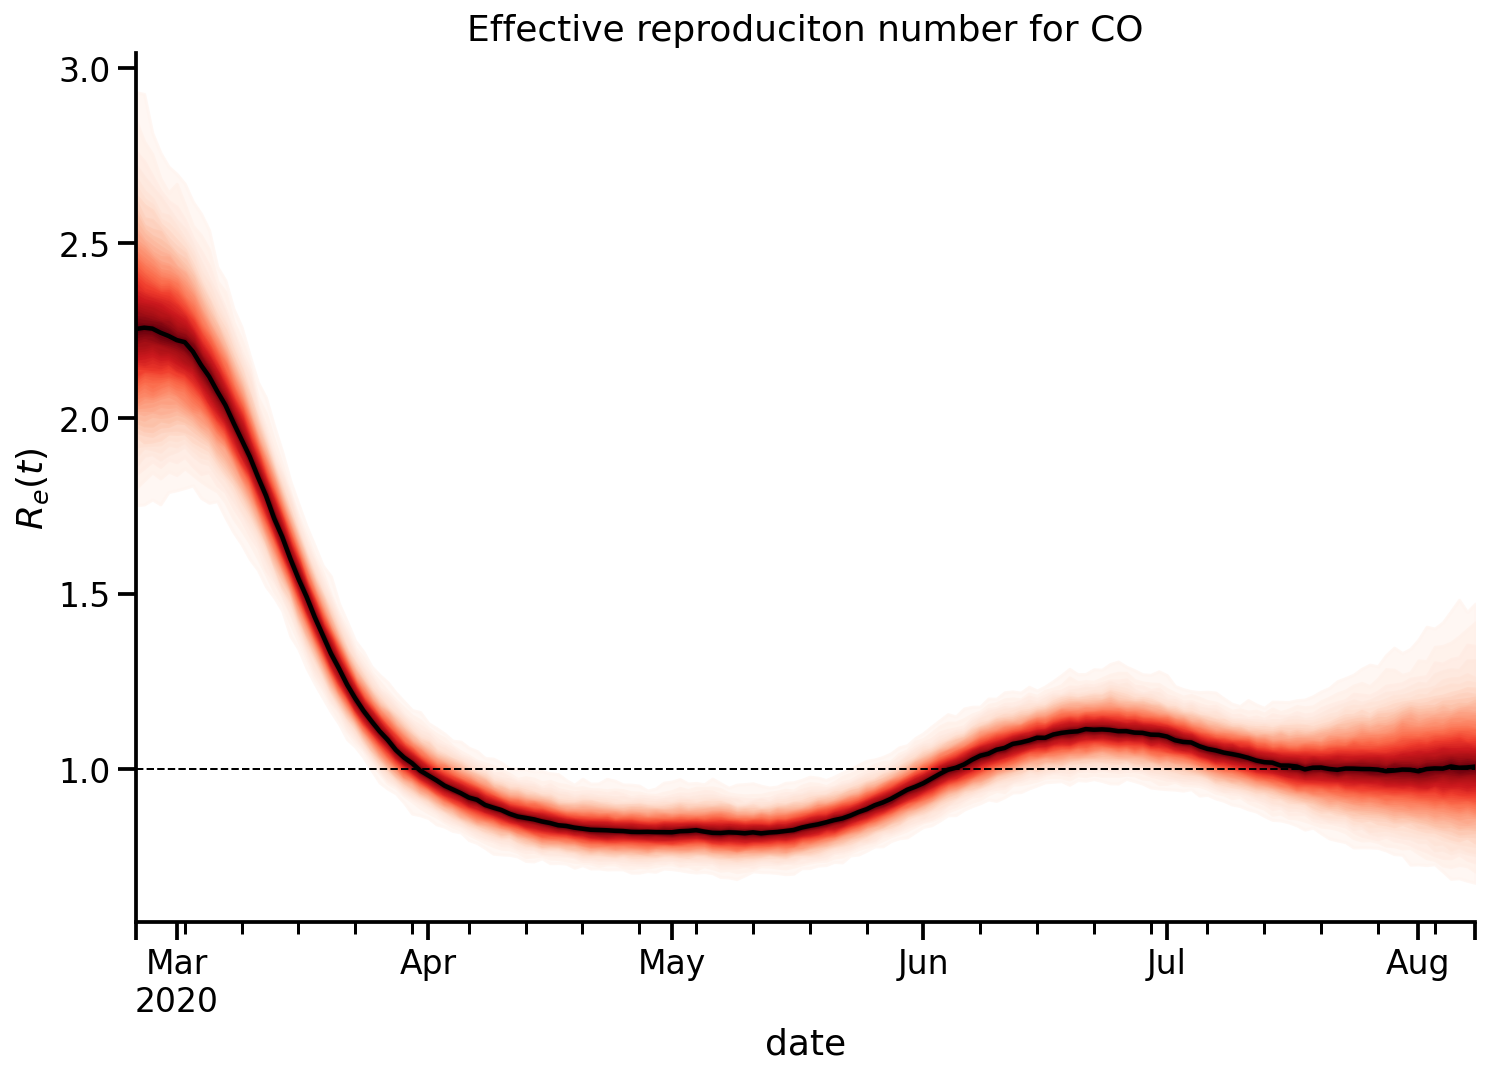

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
 
ax.set(title=f"Effective reproduciton number for {region}", ylabel="$R_e(t)$")
samples = gm.trace["r_t"]
x = result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
sns.despine();

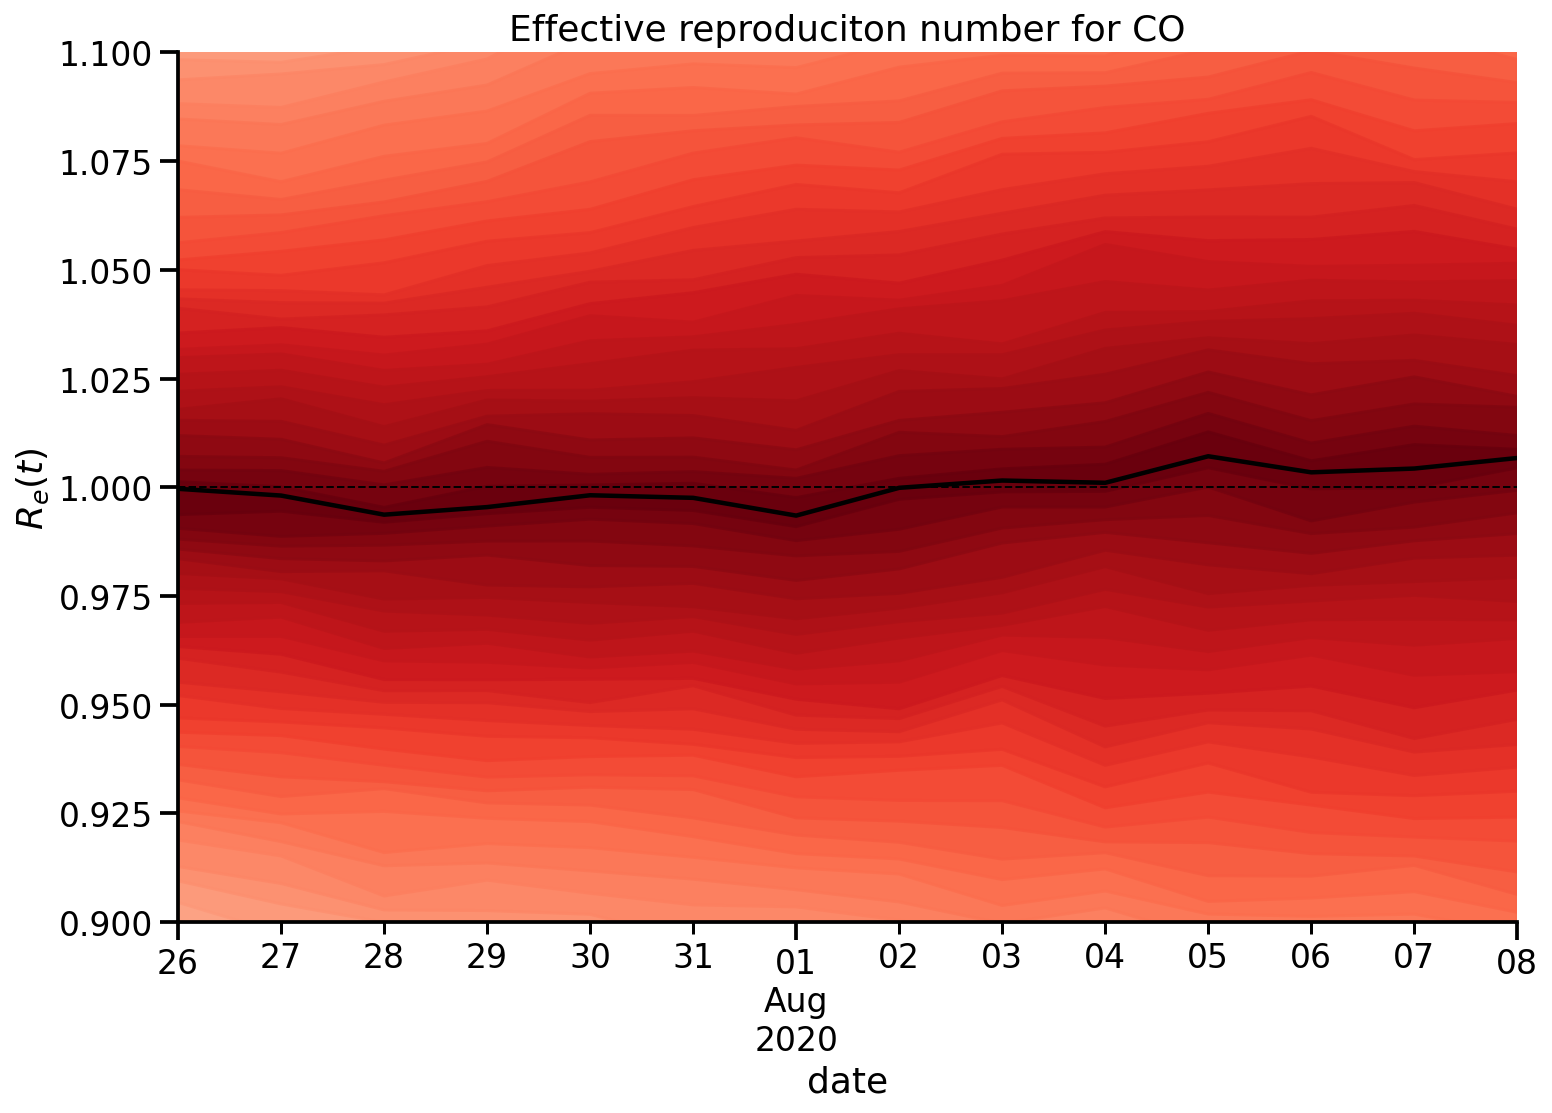

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
 
ax.set(title=f"Effective reproduciton number for {region}", ylabel="$R_e(t)$")
samples = gm.trace["r_t"]
x = result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim([result.index[-14],result.index[-1]])
ax.set_ylim([.9,1.1])
sns.despine();

## What's next?

The model handles quite a few issues that most other models do not. But like any model there are many ways to improve it. Including death data as well as hospitalizations will certainly improve the $R_e(t)$ estimate. So would a [hierarchical model](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/) that pools information across states.

Of course, we would also like to apply the model to other countries. The main difficulty here is that we do not have data on the number of tests performed for most countries. [Michael Osthege](https://twitter.com/theCake) has run the model successfully for Germany, however.

Another really interesting direction is inclusion of covariates, like lock-downs, cell-phone data, social distancing, mask-usage etc.

Interested to help out? The model as well as the dashboard are open source, contributions are welcome: https://github.com/rtcovidlive/covid-model. 